# Classifying Wine with k-nearest neighbours

## 1. Exploratory Data Analysis

We are going to be working with the **Wine** dataset. This is a 178 sample dataset that categorises 3 different types of Italian wine using 13 different features. The code below loads the Wine dataset and selects a subset of features. 

In [1]:
# set matplotlib backend to inline
%matplotlib inline 

# import modules
from sklearn import datasets 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

# load data
wine=datasets.load_wine()
print(wine.DESCR)

# this dataset has 13 features, we will only choose a subset of these
df_wine = pd.DataFrame(wine.data, columns = wine.feature_names )
selected_features = ['alcohol','flavanoids','color_intensity','ash']

# extract the data as numpy arrays of features, X, and target, y
X = df_wine[selected_features].values
y = wine.target

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

### 1.1. Visualising the data

In [2]:
# define plotting function
import seaborn as sb

def myplotGrid(X, y, cols):
    """
    This function returns a pairplot of scattergrams with histograms plotted across the pairplot diagonal. 
    
    Inputs:
        X = Dataset X values 
            e.g. X = df_wine[selected_features].values
        y = Dataset y values
            e.g. y = wine.target
        cols = List of column names
            e.g. selected_features = ['alcohol','flavanoids','color_intensity','ash']
            
    """
    
    df = pd.DataFrame(data = X, columns = cols) #Creating dataframe for ease of plotting
    df['class_type'] = y.tolist() #Adding classification data column    
    g = sb.pairplot(data = df, hue = 'class_type', palette='GnBu_d', plot_kws={'alpha':0.75}, diag_kind= 'hist') #Plotting with alpha due to overlapping datapoints
    g.fig.set_size_inches(15,15);
    
#(Zach, 2020)
#(stackoverflow, 2021)

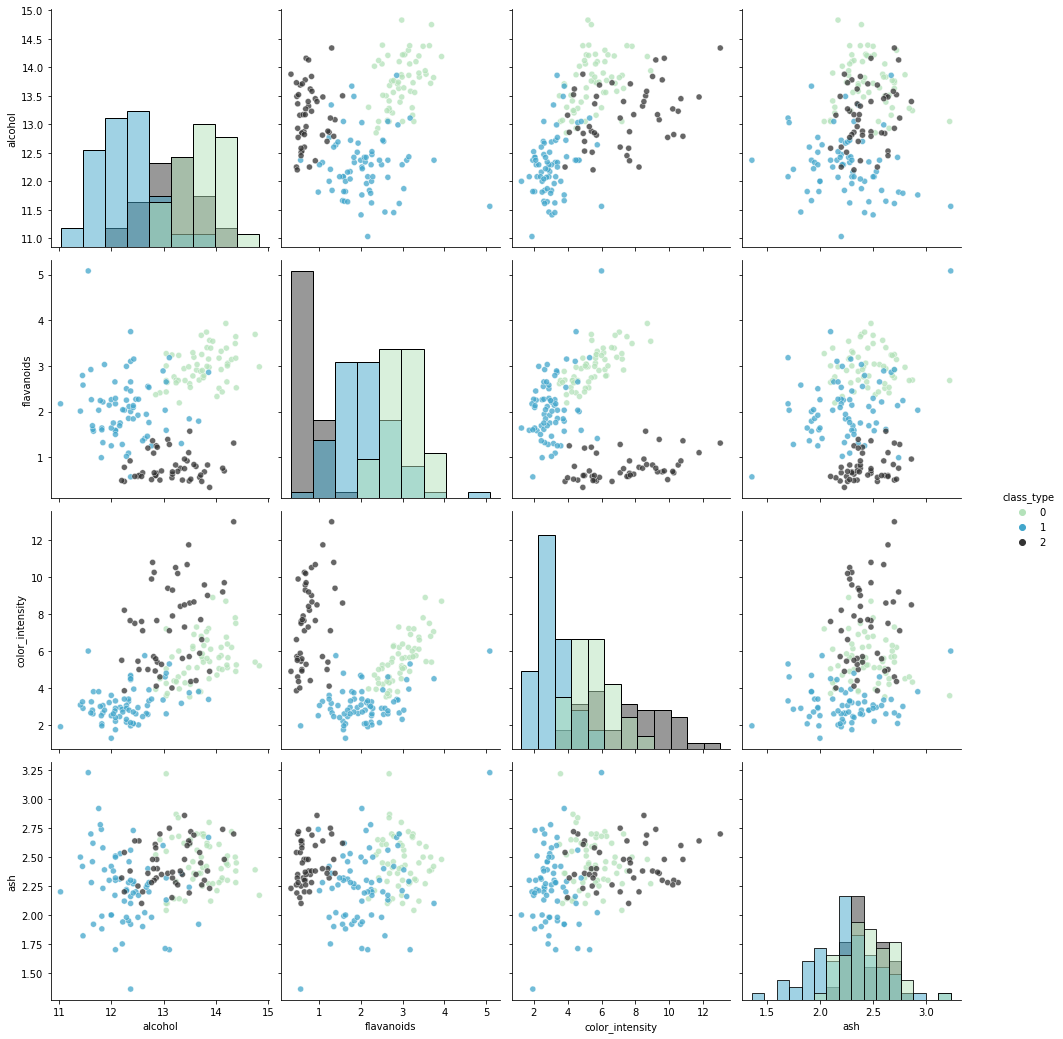

In [3]:
#Applying plotting function
wine=datasets.load_wine() #Loading dataset
df_wine = pd.DataFrame(wine.data, columns = wine.feature_names) #Creating dataframe 
selected_features = ['alcohol','flavanoids','color_intensity','ash'] #Identifying features 
X = df_wine[selected_features].values #Appending X values to variable X
y = wine.target #Collecting classification data

myplotGrid(X, y, selected_features) #Applying function

### 1.2. Exploratory Data Analysis under noise

When data are collected under real-world settings they usually contain some amount of noise that makes classification more challenging. In the cell below, I will create a noisy version of the dataset X.

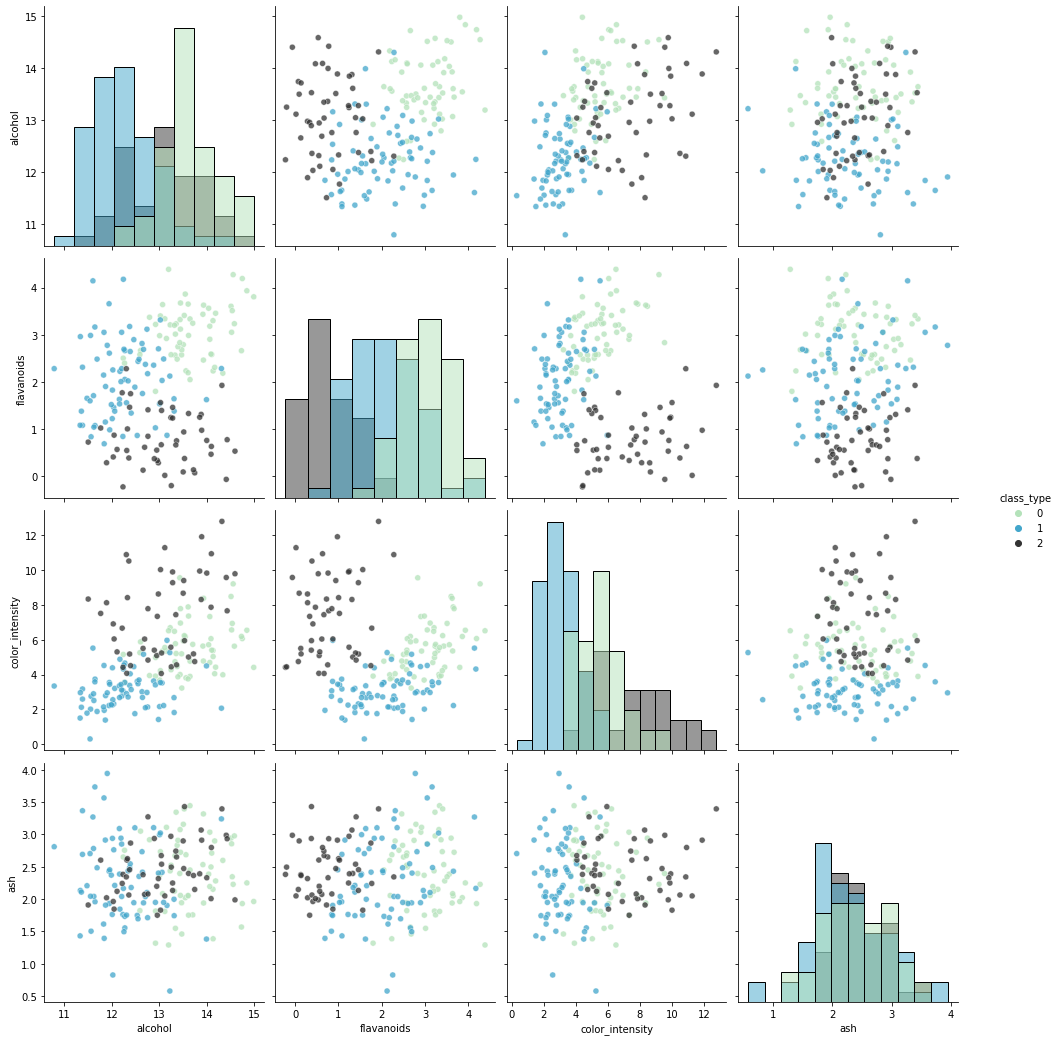

In [4]:
#Noise code 
mySeed = 12345 
np.random.seed(mySeed) #Initialize random seed to replicate results over different runs 
XN = X+np.random.normal(0,0.5,X.shape) #Applying gaussian noise to the dataset 

myplotGrid(XN, y, selected_features) #Re-running function with noisy data

## 2. Implementing kNN

Developing k-Nearest Neighbour classification.

### 2.1 Dataset Split

In [5]:
from sklearn.utils import shuffle

#Shuffling and splitting the dataset to test and train
def split_it(X,y,test_size):
    """
    The split_it function shuffles X and y input values and splits them into X_train, X_test, y_train, y_test according to the test_size selected by the user.
    
    Inputs:
        X = Dataset X values 
            e.g. X = df_wine[selected_features].values
        y = Dataset y values
            e.g. y = wine.target
        test_size = Proportion of the dataset assigned to testing
            e.g. test_size = 0.40
            
    Output:
        X_train, X_test, y_train, y_test
        
    """
    X, y = shuffle(X, y) #Randomising X and y values

    #Splitting array into train and test
    if (X.shape[0] * test_size) % 2 == 1: #If test size is an even number for X
        end_test = int(X.shape[0] * test_size) #Setting clear points to cut the dataset based upon the test_size specified
        start_train = X.shape[0] - end_test

        X_train = X[start_train:]
        X_test = X[:end_test]    

    else: #If test size is an odd number for X
        end_test = int(round(X.shape[0] * test_size, 0)) #Using round to ensure the entire dataset is split 

        X_train = X[end_test:]
        X_test = X[:end_test]


    if (y.shape[0] * test_size) % 2 == 1: #If test size is an even number for y
        end_test = int(y.shape[0] * test_size) #Setting clear points to cut the dataset based upon the test_size specified
        start_train = y.shape[0] - end_test

        y_train = y[start_train:]
        y_test = y[:end_test]    

    else: #If test size is an odd number for y
        end_test = int(round(y.shape[0] * test_size, 0)) #Using round to ensure the entire dataset is split

        y_train = y[end_test:]
        y_test = y[:end_test]

    return X_train, X_test, y_train, y_test
        
#(stackoverflow, 2014)
#(javapoint, n.d.)

### 2.2 Feature Scaling

In [6]:
#Feature scaling/ normalisation 
def feature_scaling(X_train, X_test):
    """
    The feature_scaling function normalises a datasets X values by applying ((x - minimum)/range) to each value within a column array.
    
    Inputs:
        X_train = Dataset training values
        X_test = Dataset testing values
        
    Outputs:
        scaled_train_output, scaled_test_output
        
    """

    scaled_train_output = np.array([]) #Capturing normalised output in arrays
    scaled_test_output = np.array([])
    
    X_train_t = X_train.transpose() #Transposing the dataset to itterate through each column independently
    X_test_t = X_test.transpose()

    for col in range(X_train_t.shape[0]):
        if X_train_t[col].min() < X_test_t[col].min(): #Setting max/min values from the heighest/lowest values in the dataset
            minimum = X_train_t[col].min()
        else:
            minimum = X_test_t[col].min() #Selecting min/max from either the train or test dataset

        if X_train_t[col].max() > X_test_t[col].max(): #Setting max/min values from the heighest/lowest values in the dataset
            maximum = X_train_t[col].max()
        else:
            maximum = X_test_t[col].max() #Selecting min/max from either the train or test dataset

        rangee = maximum - minimum #Calculating the range

        feature_s = [] #Applying feature scaling to train dataset on a column to column basis
        for x in X_train[:,col]:
            feature_s.append(((x - minimum)/rangee))

        if scaled_train_output.size == 0: #If scaled_output list is empty create a new list with the elements of feature_s 
            scaled_train_output = np.asarray(feature_s) 

        else: #Else add the elements of feature_s to the already established scaled_output list
            scaled_train_output = pd.DataFrame(scaled_train_output) #Converting to a dataframe to add the feature scaling for each column as np.column_stack/ concatenation/ .append cannot be used     
            scaled_train_output['feature_s'] = feature_s
            scaled_train_output = np.asarray(scaled_train_output) #Converting back to an array

        feature_s_test = [] #Repeating steps for the test dataset - Applying feature scaling
        for x in X_test[:,col]:
            feature_s_test.append(((x - minimum)/rangee))

        if scaled_test_output.size == 0: #If scaled_output list is empty create a new list with the elements of feature_s_test 
            scaled_test_output = np.asarray(feature_s_test)

        else: #Else add feature_s to scaled_output
            scaled_test_output = pd.DataFrame(scaled_test_output) #Converting to a dataframe to add the feature scaling for each column as np.column_stack/ concatenation/ .append cannot be used   
            scaled_test_output['feature_s_test'] = feature_s_test
            scaled_test_output = np.asarray(scaled_test_output) #Converting back to an array

        scaled_train_output = scaled_train_output.transpose() #Re-transposing output
        scaled_test_output = scaled_test_output.transpose()

        return scaled_train_output, scaled_test_output

### 2.3 K-Nearest Neighbours

In [7]:
#Euclidean distance calculation
def euclidean_distance(row_1, row_2):
    """
    This function calculates the euclidean distance among two rows. This is intended to be a sub-function to be applied within the wider function nearest_neighbours.
        
    """
    euclidean_d = 0
    for i in range(len(row_1)):
        euclidean_d += np.sqrt((row_1[i] - row_2[i])**2) #Applying Euclidean Distance calculation between two rows
    return euclidean_d

#Manhattan distance calculation
def manhattan_distance(row_1, row_2):
    """
    This function calculates the manhattan distance among two rows. This is intended to be a sub-function applied within the wider function nearest_neighbours.
        
    """

    manhattan_d = 0
    for i in range(len(row_1)):
        manhattan_d += np.abs(row_1[i] - row_2[i]).sum() #Applying Manhattan Distance calculation between two rows
    return manhattan_d

#K-nearest neighbours
def nearest_neighbours(train_dataset, test_row, k, distance_calculation):
    """
    This function returns k nearest neighbours for a dataset using either the euclidean distance or manhattan distance. This is intended to be a sub-function applied within the wider function classifications_function.
        
    """

    if distance_calculation == 'euclidean':        
        euclidean_d = []
        for i in train_dataset:
            distance = euclidean_distance(test_row, i) #Applying Euclidean Distance between a test dataset record and every training dataset record
            euclidean_d.append((i, distance)) 
        euclidean_d.sort(key=lambda item2: item2[1]) #Sorting Euclidean Distances to identify nearest neighbours
        nearest_neighbours = []
        for i in range(k):
            nearest_neighbours.append(euclidean_d[i][0]) #Appending k nearest neighbours to list
        return nearest_neighbours

    elif distance_calculation == 'manhattan':
        manhattan_d = []
        for i in train_dataset:
            distance = manhattan_distance(test_row, i) #Applying Manhattan Distance between a test dataset record and every training dataset record
            manhattan_d.append((i, distance)) 
        manhattan_d.sort(key=lambda item2: item2[1]) #Sorting Manhattan Distances to identify nearest neighbours
        nearest_neighbours = []
        for i in range(k):
            nearest_neighbours.append(manhattan_d[i][0]) #Appending k nearest neighbours to list
        return nearest_neighbours
    
    else:
        print("Error: Please set your distance measurement as either 'euclidean' or 'manhattan'")

#Prediction classification function        
def classifications_function(train_dataset, test_row, k, distance_calculation):
    """
    This function returns a k-nearest neighbour classification prediction using either the euclidean or manhattan distance and k nearest neighbours. This is intended to be a sub-function applied within the wider function knn_function.
        
    """

    neighbors = nearest_neighbours(train_dataset, test_row, k, distance_calculation) #Applying nearest_neighbours function between a test dataset record and every training dataset record
    neighbors_output = [row[-1] for row in neighbors]
    prediction = max(set(neighbors_output), key=neighbors_output.count) #Returning the most frequent class by count
    return prediction
    
#Complete KNN function    
def knn_function(X_train, X_test, y_train, y_test, k, distance_calculation, feature_scaling):
    """
    This function returns k-nearest neighbour classification predictions for a dataset.
    
    Inputs:
        X_train = Array of X training dataset values
        X_test = Array of X testing dataset values
        y_train = Array of y training dataset values
        y_test = Array of y testing dataset values
        k = Number (k) of nearest neighbours 
        distance_calculation = Distance calculation to be applied, either 'euclidean' or 'manhattan'
        feature_scaling = Feature scaling normalisation. This should be set as either 'on' or 'off'
        
    Output:
        This function outputs an array of k-nearest neighbour classification predictions.
    
        
    """
    
    if feature_scaling == 'on':
        X_train_feat, X_test_feat = feature_scaling(X_train, X_test) #Applying feature scaling

        train_dataset = pd.DataFrame(X_train_feat) #Converting to a dataframe to add y_train as np.column_stack/ concatenation/ .append cannot be used
        train_dataset['y'] = y_train
        train_dataset = np.asarray(train_dataset) #Converting back to an array 
        test_dataset = pd.DataFrame(X_test_feat) #Converting to a dataframe to add y_test as np.column_stack/ concatenation/ .append cannot be used
        test_dataset['y'] = y_test
        test_dataset = np.asarray(test_dataset) #Converting back to an array

        knn_applied = []
        for i in test_dataset:
            classifications = classifications_function(train_dataset, i, k, distance_calculation) #Applying classifications_function to entire test_dataset  
            knn_applied.append(int(classifications))
        return(np.asarray(knn_applied))

    elif feature_scaling == 'off':
        train_dataset = pd.DataFrame(X_train) #Converting to a dataframe to add y_train as np.column_stack/ concatenation/ .append cannot be used
        train_dataset['y'] = y_train
        train_dataset = np.asarray(train_dataset) #Converting back to an array 
        test_dataset = pd.DataFrame(X_test) #Converting to a dataframe to add y_test as np.column_stack/ concatenation/ .append cannot be used
        test_dataset['y'] = y_test
        test_dataset = np.asarray(test_dataset) #Converting back to an array

        knn_applied = []
        for i in test_dataset:
            classifications = classifications_function(train_dataset, i, k, distance_calculation) #Applying classifications_function to entire test_dataset  
            knn_applied.append(int(classifications))
        return(np.asarray(knn_applied))
    
    else:
        print("Error: Please set your feature scaling as either 'on' or 'off'")

#(Brownlee, 2019)
#(Zach, 2021)

### 2.4 Applying Split/ K-Nearest Neighbour Functions

In [8]:
#Splitting dataset
test_size = 0.50
X_train, X_test, y_train, y_test = split_it(X,y,test_size) 

In [9]:
#Applying K-nearest neighbours function
y_pred = knn_function(X_train, X_test, y_train, y_test, 5, 'euclidean', 'off') 

print(y_test)
print(y_pred)

[2 2 0 0 1 2 2 1 2 0 2 1 2 2 2 0 1 2 2 1 0 2 0 1 1 0 0 1 1 2 1 0 0 2 2 1 1
 1 1 2 1 1 1 1 0 1 0 2 1 0 1 1 2 2 2 1 2 1 1 1 1 0 0 0 2 0 0 0 1 2 0 1 1 1
 0 1 2 2 0 2 2 1 0 0 1 1 0 0 2]
[2 2 0 0 1 2 2 1 2 0 2 1 2 2 2 0 1 2 2 1 0 2 0 1 1 0 0 1 1 2 1 0 0 2 2 1 1
 1 1 2 1 1 1 1 0 1 0 2 1 0 1 1 2 2 2 1 2 1 1 1 1 0 0 0 2 0 0 0 1 2 0 1 1 1
 0 1 2 2 0 2 2 1 0 0 1 1 0 0 2]


## 3. Classifier evaluation

Implementing classifier evaluation code.

### 3.1 Confusion Matrix & Scores

In [10]:
#Creating Confusion Matrix
def confusion_matrix_function(y_test, y_pred):
    """
    This function creates a confusion matrix using testing data and model classification predictions.
    
    Input:
        y_test = Array of y testing data
        y_pred = Array of y classification predictions
        
    Output:
        The function returns a confusion matrix.
    
    """
    
    clusters = len(np.unique(y_test)) #Identifying matrix dimensions
    result = np.zeros((clusters, clusters)) #Setting 0's to the matrix
    for i in range(y_test.shape[0]):
        result[y_test[i]][y_pred[i]] += 1 #Summing correct predictions      
    return result

#(stackoverflow, 2010)

In [11]:
#Creating Accuracy Score
def accuracy_score_function(matrix):
    """
    This function returns a matrix accuracy score.
    
    Input:
        matrix = Confusion matrix. The function input is intended to be the output of confusion_matrix_function.

    Output:
        Matrix accuracy score.
    
    """

    return np.diagonal(matrix).sum()/matrix.sum() #Applying score to matrix

In [12]:
#Function used to extract a matrix column 
def column(matrix, i):
    """
    This function returns a column within a matrix. This is intended to be sub-function used within the function scores_base.
    
    """
    return [row[i] for row in matrix]

#Counting total positives/ false positives/ false negatives
def scores_base(matrix):
    """
    This function returns a matrix total positives, false positives and false negatives. This is intended to be sub-function used within the function precision_score_function.
    
    """
        
    tp = []
    fp = []
    fn = []
    
    positives = np.diagonal(matrix) #Correct predictions fall on the matrix diagonal
    matrix_2 = matrix.copy() 
    np.fill_diagonal(matrix_2, 0) #Removing correct predictions in a temporary matrix for ease of summing

    for i in range(len(matrix_2)):
        tp.append(positives[i]) #Correct predictions fall on the matrix diagonal
        fp.append(sum(column(matrix_2, i))) #Using column function to sum false positives
        fn.append(sum(matrix_2[i])) #Summing false negatives
        
    return tp, fp, fn

#Creating precision score using both macro/ micro methodologies
def precision_score_function(matrix, calculation):
    """
    This function calculates matrix precision using the output of the scores_base function. The calculation can be either macro or micro.
    
    Input:
        matrix = Confusion matrix. The function input is intended to be the output of confusion_matrix_function.
        calculation = The calculation can either be 'macro' or 'micro' precision
        
    Output:
        The output of this function is the matrix precision score.
    
    """
    
    precision = []
    tp, fp, fn = scores_base(matrix) #Applying function to return the inputs to the precision score
    
    for i in range(len(matrix)):
        precision.append(tp[i]/(tp[i]+fp[i])) #Appending precision per row to be used in macro precision calculation
        
    s_tp = sum(tp)
    s_fn = sum(fn)
    s_fp = sum(fp)
    
    if calculation == "micro":
        micro = (s_tp/(s_tp + s_fp)) #micro precision
        return micro
    
    elif calculation == "macro":
        return (sum(precision)/3) #macro precision

    else:
        print("Error: Please select calculation as 'micro' or 'macro'")

#Creating recall score using both macro/ micro methodologies        
def recall_score_function(matrix, calculation):
    """
    This function calculates matrix recall using the output of the scores_base function. The calculation can be either macro or micro.
    
    Input:
        matrix = Confusion matrix. The function input is intended to be the output of confusion_matrix_function.
        calculation = The calculation can either be 'macro' or 'micro' precision
        
    Output:
        The output of this function is the matrix recall score.
    
    """
    
    recall = []
    tp, fp, fn = scores_base(matrix)
    
    for i in range(len(matrix)):
        recall.append(tp[i]/(tp[i]+fn[i])) #Appending recall per row to be used in macro precision calculation
        
    s_tp = sum(tp)
    s_fn = sum(fn)
    s_fp = sum(fp)
    
    if calculation == "micro":
        micro = (s_tp/(s_tp + s_fp)) #micro recall
        return micro
    
    elif calculation == "macro":
        return (sum(recall)/3) #macro recall

    else:
        print("Error: Please select calculation as 'micro' or 'macro'")
        
#(stackoverflow, 2009)
#(Kumar, 2020)

### 3.2 Applying Classifier Evaluation Functions

In [13]:
#Applying confusion matrix function
matrix = confusion_matrix_function(y_test, y_pred)

In [14]:
#Printing confusion matrix and key scores
print(matrix)
print("Accuracy Score: ", accuracy_score_function(matrix))
print("Precision Score: ", precision_score_function(matrix, "micro"))
print("Recall Score: ", recall_score_function(matrix, "macro"))

[[26.  0.  0.]
 [ 0. 35.  0.]
 [ 0.  0. 28.]]
Accuracy Score:  1.0
Precision Score:  1.0
Recall Score:  1.0


## 4. Nested Cross-validation using your implementation of KNN

5-fold nested cross-validation with k-NN.

### 4.1 Building Cross-validation Functions

In [15]:
#Randomising and splitting data
def random_perm(mySeed, nFolds, X):
    """
    This function creates an array of random index permutations. The number of permutations is split by the input nFolds. This is intended to be a sub-function applied within the wider myNestedCrossVal function.

    """
    
    np.random.seed(mySeed)
    indices = np.random.permutation(np.arange(0,len(X),1)) # Creates an array of random permutation of indices between 0 and the length of the X data.
    indices = np.array_split(indices, nFolds) # The indices are then split up into folds
    return indices

In [16]:
#Nested cross-validation function
def myNestedCrossVal(X, y, nFolds, nearest_neighbour, distance_calculation, validation_test_size, mySeed):
    """
    This function applies a k-nearest neighbour cross-validation function.

    Inputs:
        X = Array of dataset X values 
        y = Array of dataset y values
        nFolds = Number of cross-validation folds 
        nearest_neighbour = Number (k) of nearest neighbours 
        distance_calculation = Distance calculation to be applied, either 'euclidean' or 'manhattan'
        validation_test_size = Proportion of the dataset assigned to validation testing 
        mySeed = Setting random numnber generator

    Output:
        distinct_accuracies = The function outputs the distinct set of parameters and accuracy scores for each test run in the function.  
        top_accuracy_vals = The fuction also outputs the top best hyperparameter combination for each fold
        

    """
    
    indices = random_perm(mySeed, nFolds, X) #Applying random_perm function
    fold_accuracy_vals = []
    k_vals = []
    distance_vals = []
    matrix_vals = []
    distinct_accuracies = []
    top_accuracy_vals = []   
    
    knn_list = []
    for k in nearest_neighbour:
        knn_list.append(k) #Appending nearest neighbours inputs to a list
        
    distance_list = []
    for dist in distance_calculation:
        distance_list.append(dist) #Appending distance inputs to a list
        
    for iFold in range(0,nFolds):
        testFold = indices[iFold] #Using index to split data into fold testing data  
        trainFold = np.concatenate(indices)
        trainFold = np.asarray([i for i in trainFold if i not in testFold]) #Selecting non-testing data as fold training data 

        X_train = X[trainFold] #Training data
        y_train = y[trainFold]
        X_test = X[testFold] #Testing data
        y_test = y[testFold]

        X_trainFold, X_valuation, y_trainFold, y_valuation = split_it(X_train, y_train, validation_test_size) #Splitting fold training data into train and valuation

        for k in knn_list:
            for dist in distance_list:
                y_predFold = knn_function(X_trainFold, X_valuation, y_trainFold, y_valuation, k, dist, 'off') #Looping through all hyperparameters and performing k nearest neighbours
                matrixFold = confusion_matrix_function(y_valuation, y_predFold) #Creating matrices
                fold_accuracy_vals.append([accuracy_score_function(matrixFold)]) #Appending accuracies

                k_vals.append([k])
                distance_vals.append([dist])
                matrix_vals.append([matrixFold])                
                distinct_accuracies.append([iFold, k, dist, [accuracy_score_function(matrixFold)]]) #Accuracy per distinct set of parameters  
       
        pos = np.asarray(np.where(fold_accuracy_vals == np.max(fold_accuracy_vals, 0))[0])[0] #identifying the top performing hyperparameter combination within the fold, if there's more than 1 top performer, the first computed result will be returned
        
        top_dist = ""
        for d in distance_vals[pos]:
            top_dist += d #Converting the top performing distance to string to pass in knn_function
            
        for i in k_vals[pos]:
            top_k = int(i) #Converting the top performing k nearest neighbours to integer to pass in knn_function
                    
        y_predFold = knn_function(X_train, X_test, y_train, y_test, top_k, top_dist, 'off') #Applying K Nearest Neighbours on the top performing hyperparameter combination with the folds test and train data 
        matrixFold = confusion_matrix_function(y_test, y_predFold) #Creating confusion matrices
        accuracyFold = accuracy_score_function(matrixFold) #Calculating accuracy score
        
        top_accuracy_vals.append([iFold, top_k, 
                              top_dist,
                              accuracyFold, 
                              matrixFold]) #Appending top performing hyperparameter combination for each fold
        
    return distinct_accuracies, top_accuracy_vals

In [17]:
#Total cross-validation accuracy
def cross_val_total_accuracy(top_accuracy_vals): #Simple function to calculate accuracy accross folds
    """
    This function outputs the average accuracy accross the top performing hyperparameter combinations. The function input is intended to be the top_accuracy_vals ouput from the function myNestedCrossVal.
    
    """
    
    accuracies = []
    for i in range(len(top_accuracy_vals)):
        accuracies.append(top_accuracy_vals[i][3])
    return np.sum(accuracies)/len(top_accuracy_vals)

In [18]:
#Total cross-validation accuracy standard deviation
def cross_val_std(top_accuracy_vals): #Simple function to calculate standard deviation accross folds
    """
    This function outputs the average standard deviation accross the top performing hyperparameter combinations. The function input is intended to be the top_accuracy_vals ouput from the function myNestedCrossVal.
    
    """

    standard_d = []
    for i in range(len(top_accuracy_vals)):
        standard_d.append(top_accuracy_vals[i][3])
    return np.std(standard_d)

### 4.2 Applying Cross-validation Functions to Clean Data

In [19]:
#Applying nested cross-validation function and outputting distinct accuracies
distinct_accuracies, top_accuracy_vals = myNestedCrossVal(X, y, 5, list(range(1,10)),['euclidean', 'manhattan'], 0.5, 42)

print('Please read as: Fold, K-Nearest Neighbours, Distance Calculation, Accuracy')
distinct_accuracies

Please read as: Fold, K-Nearest Neighbours, Distance Calculation, Accuracy


[[0, 1, 'euclidean', [0.971830985915493]],
 [0, 1, 'manhattan', [0.971830985915493]],
 [0, 2, 'euclidean', [0.971830985915493]],
 [0, 2, 'manhattan', [0.971830985915493]],
 [0, 3, 'euclidean', [0.971830985915493]],
 [0, 3, 'manhattan', [0.971830985915493]],
 [0, 4, 'euclidean', [0.971830985915493]],
 [0, 4, 'manhattan', [0.971830985915493]],
 [0, 5, 'euclidean', [0.971830985915493]],
 [0, 5, 'manhattan', [0.971830985915493]],
 [0, 6, 'euclidean', [0.971830985915493]],
 [0, 6, 'manhattan', [0.971830985915493]],
 [0, 7, 'euclidean', [0.971830985915493]],
 [0, 7, 'manhattan', [0.971830985915493]],
 [0, 8, 'euclidean', [0.9577464788732394]],
 [0, 8, 'manhattan', [0.9577464788732394]],
 [0, 9, 'euclidean', [0.971830985915493]],
 [0, 9, 'manhattan', [0.971830985915493]],
 [1, 1, 'euclidean', [0.971830985915493]],
 [1, 1, 'manhattan', [0.971830985915493]],
 [1, 2, 'euclidean', [0.971830985915493]],
 [1, 2, 'manhattan', [0.971830985915493]],
 [1, 3, 'euclidean', [1.0]],
 [1, 3, 'manhattan', [1

In [20]:
#Outputting the best performing parameters per fold
print('Please read as: Fold, K-Nearest Neighbours, Distance Calculation, Accuracy, Confusion Matrix')
top_accuracy_vals

Please read as: Fold, K-Nearest Neighbours, Distance Calculation, Accuracy, Confusion Matrix


[[0,
  1,
  'euclidean',
  0.9722222222222222,
  array([[14.,  0.,  0.],
         [ 1., 13.,  0.],
         [ 0.,  0.,  8.]])],
 [1,
  3,
  'euclidean',
  1.0,
  array([[12.,  0.,  0.],
         [ 0., 13.,  0.],
         [ 0.,  0., 11.]])],
 [2,
  3,
  'euclidean',
  1.0,
  array([[10.,  0.,  0.],
         [ 0., 17.,  0.],
         [ 0.,  0.,  9.]])],
 [3,
  3,
  'euclidean',
  1.0,
  array([[12.,  0.,  0.],
         [ 0., 13.,  0.],
         [ 0.,  0., 10.]])],
 [4,
  3,
  'euclidean',
  0.9714285714285714,
  array([[11.,  0.,  0.],
         [ 1., 13.,  0.],
         [ 0.,  0., 10.]])]]

In [21]:
print('Total cross-validation accuracy:', cross_val_total_accuracy(top_accuracy_vals))
print('Total cross-validation accuracy standard deviation:', cross_val_std(top_accuracy_vals))

Total cross-validation accuracy: 0.9887301587301588
Total cross-validation accuracy standard deviation: 0.01380496184454534


### 4.3 Applying Cross-validation Functions to Noisy Data

In [22]:
# noise code 
# initialize random seed to replicate results over different runs
mySeed = 42 
np.random.seed(mySeed) 
XN = X+np.random.normal(0,3, X.shape)

In [23]:
#Applying nested cross-validation function to noisy data and outputting distinct accuracies
noise_distinct_accuracies, noise_top_accuracy_vals = myNestedCrossVal(XN, y, 5, list(range(1,10)),['euclidean', 'manhattan'], 0.5, 42)

print('Please read as: Fold, K-Nearest Neighbours, Distance Calculation, Accuracy')
noise_distinct_accuracies

Please read as: Fold, K-Nearest Neighbours, Distance Calculation, Accuracy


[[0, 1, 'euclidean', [0.5492957746478874]],
 [0, 1, 'manhattan', [0.5492957746478874]],
 [0, 2, 'euclidean', [0.5070422535211268]],
 [0, 2, 'manhattan', [0.5070422535211268]],
 [0, 3, 'euclidean', [0.5774647887323944]],
 [0, 3, 'manhattan', [0.5774647887323944]],
 [0, 4, 'euclidean', [0.6197183098591549]],
 [0, 4, 'manhattan', [0.6197183098591549]],
 [0, 5, 'euclidean', [0.6197183098591549]],
 [0, 5, 'manhattan', [0.6197183098591549]],
 [0, 6, 'euclidean', [0.6056338028169014]],
 [0, 6, 'manhattan', [0.6056338028169014]],
 [0, 7, 'euclidean', [0.6197183098591549]],
 [0, 7, 'manhattan', [0.6197183098591549]],
 [0, 8, 'euclidean', [0.647887323943662]],
 [0, 8, 'manhattan', [0.647887323943662]],
 [0, 9, 'euclidean', [0.676056338028169]],
 [0, 9, 'manhattan', [0.676056338028169]],
 [1, 1, 'euclidean', [0.5352112676056338]],
 [1, 1, 'manhattan', [0.5352112676056338]],
 [1, 2, 'euclidean', [0.5633802816901409]],
 [1, 2, 'manhattan', [0.5633802816901409]],
 [1, 3, 'euclidean', [0.591549295774

In [24]:
#Outputting the best performing parameters per fold on noisy data
print('Please read as: Fold, K-Nearest Neighbours, Distance Calculation, Accuracy, Confusion Matrix')
noise_top_accuracy_vals

Please read as: Fold, K-Nearest Neighbours, Distance Calculation, Accuracy, Confusion Matrix


[[0,
  9,
  'euclidean',
  0.7222222222222222,
  array([[ 9.,  3.,  2.],
         [ 2., 11.,  1.],
         [ 1.,  1.,  6.]])],
 [1,
  9,
  'euclidean',
  0.5833333333333334,
  array([[5., 7., 0.],
         [4., 8., 1.],
         [1., 2., 8.]])],
 [2,
  7,
  'euclidean',
  0.7777777777777778,
  array([[ 7.,  3.,  0.],
         [ 2., 15.,  0.],
         [ 1.,  2.,  6.]])],
 [3,
  5,
  'euclidean',
  0.7428571428571429,
  array([[10.,  1.,  1.],
         [ 1., 11.,  1.],
         [ 0.,  5.,  5.]])],
 [4,
  5,
  'euclidean',
  0.7142857142857143,
  array([[ 9.,  2.,  0.],
         [ 2., 12.,  0.],
         [ 2.,  4.,  4.]])]]

In [25]:
print('Total cross-validation accuracy:', cross_val_total_accuracy(noise_top_accuracy_vals))
print('Total cross-validation accuracy standard deviation:', cross_val_std(noise_top_accuracy_vals))

Total cross-validation accuracy: 0.7080952380952381
Total cross-validation accuracy standard deviation: 0.06613240191478298


## 5. Summary of results [6 pts]

**Clean** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | 0.9722222222222222  |  1 | euclidean  |
| 2 | 1.0  |  3 | euclidean  |
| 3 | 1.0  |  3 | euclidean  |
| 4 | 1.0  |  3 | euclidean  |
| 5 | 0.9714285714285714  |  3 | euclidean  |
| **total** | 0.9887301587301588 | $\pm$ 0.01380496184454534  |    |

Where **total** is given as an average over all the folds, and $\pm$ the standard deviation.

**Noisy** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | 0.7222222222222222  |  9 | euclidean  |
| 2 | 0.5833333333333334  |  9 | euclidean  |
| 3 | 0.7777777777777778  |  7 | euclidean  |
| 4 | 0.7428571428571429  |  5 | euclidean  |
| 5 | 0.7142857142857143  |  5 | euclidean  |
| **total** | 0.7080952380952381 | $\pm$ 0.06613240191478298  |    |


### 5.2. Confusion matrix summary

Summarising the overall results of the nested cross validation K-NN algorithm.

### 5.2 Clean Data Summary

In [26]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
confusion_summary = pd.DataFrame(np.vstack(top_accuracy_vals), dtype=object, columns = ['Fold', 'k', 'distance', 'accuracy', 'matrix']) #Converting array to Dataframe
confusion_summary.drop(columns=['matrix'], inplace=True) #Dropping matrices from dataframe
confusion_summary.set_index('Fold', inplace=True) #Setting fold as the index
confusion_summary = confusion_summary.reindex(columns=['accuracy', 'k', 'distance']) #Re-ordering columns
confusion_summary.index += 1 #Setting index to begin at 1 

print('CLEAN')
# clean data summary results
confusion_summary

CLEAN


,accuracy,k,distance
Fold,,,
1,0.972222,1,euclidean
2,1,3,euclidean
3,1,3,euclidean
4,1,3,euclidean
5,0.971429,3,euclidean


In [27]:
print('Total cross-validation accuracy:', confusion_summary['accuracy'].sum()/len(confusion_summary['accuracy']))
print('Total cross-validation standard deviation:', np.std(confusion_summary['accuracy']))

Total cross-validation accuracy: 0.9887301587301588
Total cross-validation standard deviation: 0.01380496184454534


In [28]:
matrices = []
for i in range(len(top_accuracy_vals)):
    matrices.append(pd.DataFrame(top_accuracy_vals[i][4]))

for index, k in enumerate(matrices):
    print('Fold',index+1, 'Matrix:')
    print(k)

Fold 1 Matrix:
      0     1    2
0  14.0   0.0  0.0
1   1.0  13.0  0.0
2   0.0   0.0  8.0
Fold 2 Matrix:
      0     1     2
0  12.0   0.0   0.0
1   0.0  13.0   0.0
2   0.0   0.0  11.0
Fold 3 Matrix:
      0     1    2
0  10.0   0.0  0.0
1   0.0  17.0  0.0
2   0.0   0.0  9.0
Fold 4 Matrix:
      0     1     2
0  12.0   0.0   0.0
1   0.0  13.0   0.0
2   0.0   0.0  10.0
Fold 5 Matrix:
      0     1     2
0  11.0   0.0   0.0
1   1.0  13.0   0.0
2   0.0   0.0  10.0


### 5.3 Noisy Data Summary

In [29]:
n_confusion_summary = pd.DataFrame(np.vstack(noise_top_accuracy_vals), dtype=object, columns = ['Fold', 'k', 'distance', 'accuracy', 'matrix']) #Converting array to Dataframe
n_confusion_summary.drop(columns=['matrix'], inplace=True) #Dropping matrices from dataframe
n_confusion_summary.set_index('Fold', inplace=True) #Setting fold as the index
n_confusion_summary = n_confusion_summary.reindex(columns=['accuracy', 'k', 'distance']) #Re-ordering columns
n_confusion_summary.index += 1 #Setting index to begin at 1 

print('NOISY')
# Noisy data summary results
n_confusion_summary

NOISY


,accuracy,k,distance
Fold,,,
1,0.722222,9,euclidean
2,0.583333,9,euclidean
3,0.777778,7,euclidean
4,0.742857,5,euclidean
5,0.714286,5,euclidean


In [30]:
print('Total noisy cross-validation accuracy:', n_confusion_summary['accuracy'].sum()/len(confusion_summary['accuracy']))
print('Total noisy cross-validation standard deviation:', np.std(n_confusion_summary['accuracy']))

Total noisy cross-validation accuracy: 0.7080952380952381
Total noisy cross-validation standard deviation: 0.06613240191478298


In [31]:
matrices_n = []
for i in range(len(noise_top_accuracy_vals)):
    matrices_n.append(pd.DataFrame(noise_top_accuracy_vals[i][4]))

for index, k in enumerate(matrices_n):
    print('Fold',index+1, 'Matrix:')
    print(k)

Fold 1 Matrix:
     0     1    2
0  9.0   3.0  2.0
1  2.0  11.0  1.0
2  1.0   1.0  6.0
Fold 2 Matrix:
     0    1    2
0  5.0  7.0  0.0
1  4.0  8.0  1.0
2  1.0  2.0  8.0
Fold 3 Matrix:
     0     1    2
0  7.0   3.0  0.0
1  2.0  15.0  0.0
2  1.0   2.0  6.0
Fold 4 Matrix:
      0     1    2
0  10.0   1.0  1.0
1   1.0  11.0  1.0
2   0.0   5.0  5.0
Fold 5 Matrix:
     0     1    2
0  9.0   2.0  0.0
1  2.0  12.0  0.0
2  2.0   4.0  4.0


## 7. References

Brownlee, J., 2019. Develop k-Nearest Neighbors in Python From Scratch. [Online] 
Available at: https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/
[Accessed 04 07 2021].

javapoint, n.d. Python Program to Check if a Number is Odd or Even. [Online] 
Available at: (stackoverflow, 2014)
[Accessed 04 07 2021].

Kumar, A., 2020. Micro-average & Macro-average Scoring Metrics – Python. [Online] 
Available at: https://vitalflux.com/micro-average-macro-average-scoring-metrics-multi-class-classification-python/
[Accessed 04 07 2021].

NumPy, 2021. NumPy fundamentals. [Online] 
Available at: https://numpy.org/doc/stable/user/basics.html
[Accessed 04 07 2021].

pandas, 2021. User Guide. [Online] 
Available at: https://pandas.pydata.org/pandas-docs/stable/user_guide/index.html
[Accessed 04 07 2021].

stackoverflow, 2009. How do you extract a column from a multi-dimensional array?. [Online] 
Available at: https://stackoverflow.com/questions/903853/how-do-you-extract-a-column-from-a-multi-dimensional-array
[Accessed 04 07 2021].

stackoverflow, 2010. How to write a confusion matrix in Python?. [Online] 
Available at: https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python
[Accessed 04 07 2021].

stackoverflow, 2014. Shuffle two list at once with same order. [Online] 
Available at: https://stackoverflow.com/questions/23289547/shuffle-two-list-at-once-with-same-order
[Accessed 04 07 2021].

stackoverflow, 2021. How to change a figure's size in Python Seaborn package. [Online] 
Available at: https://stackoverflow.com/questions/33446029/how-to-change-a-figures-size-in-python-seaborn-package
[Accessed 04 07 2021].

Zach, 2020. How to Add a Numpy Array to a Pandas DataFrame. [Online] 
Available at: https://www.statology.org/add-numpy-array-to-pandas-dataframe/
[Accessed 04 07 2021].

Zach, 2021. How to Calculate Manhattan Distance in Python (With Examples). [Online] 
Available at: (Brownlee, 2019)
[Accessed 04 07 2021].